In [1]:
from models.manage_models import save_model, load_model
from sklearn.ensemble import VotingClassifier
from utils.data_loader import load_split, prepare_features_target
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, fbeta_score, make_scorer
from sklearn.model_selection import learning_curve
import numpy as np

In [2]:
log_regr = load_model('probl1_logistic_regression', 'models/probl1_logistic_regression_20251225_180546.joblib')
svm = load_model('probl1_svm', 'models/probl1_svm_20251225_183323.joblib')

In [3]:
train_df = load_split('train', data_dir='dataset/splits')
X_train, y_train = prepare_features_target(train_df, target_col='Fault')

In [4]:
ensemble = VotingClassifier(
    estimators=[('lr', log_regr), ('svm', svm)],
    voting='soft',
    weights=[1,2] 
)

ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('sampler',
                                               RandomUnderSampler(random_state=42)),
                                              ('scaler', StandardScaler()),
                                              ('clf',
                                               LogisticRegression(C=10,
                                                                  class_weight='balanced',
                                                                  l1_ratio=1,
                                                                  max_iter=5000,
                                                                  penalty='elasticnet',
                                                                  random_state=42,
                                                                  solver='saga'))])),
                             ('svm',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model',
                                               SVC(C=69.84841896499474,
                                                   cache_size=2000,
                                                   class_weight='balanced',
                                                   gamma='auto',
                                                   probability=True,
                                                   random_state=42))]))],
                 voting='soft', weights=[1, 2])

In [5]:
test_df = load_split('test', data_dir='dataset/splits')
X_test, y_test = prepare_features_target(test_df, target_col='Fault')

f2_scorer en test: 0.8745372135178648
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91     13800
         1.0       0.77      0.88      0.82      6200

    accuracy                           0.88     20000
   macro avg       0.86      0.88      0.87     20000
weighted avg       0.89      0.88      0.88     20000

Matriz de confusión:


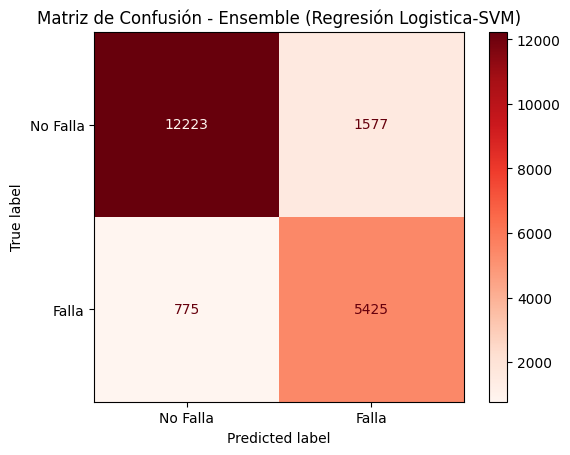

In [6]:
y_pred = ensemble.predict(X_test)

print("f2_scorer en test:",
      fbeta_score(y_test, y_pred, beta=2, average="macro"))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
# Plot it using the ConfusionMatrixDisplay imported
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=['No Falla', 'Falla'],
                             )
disp.plot(cmap='Reds')
plt.title('Matriz de Confusión - Ensemble (Regresión Logistica-SVM)')
plt.show()

In [7]:
paths = save_model(
    model=ensemble, 
    model_name='probl1_lr_svm',
    save_path='models/',
    metadata={
        'hyperparameters': ensemble.get_params()
    }
)

print(f"Modelo guardado en: {paths['model_path']}")

Modelo guardado en: models/probl1_lr_svm_20251226_115632.joblib


In [8]:
model = load_model('probl1_lr_svm', 'models/probl1_lr_svm_20251226_115632.joblib')

In [3]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [ ]:
# No se pudo probar la curva de aprendizaje, no me da la compu perdon :(
train_sizes, train_scores, val_scores = learning_curve( 
    estimator=model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),  # 10%, 32.5%, ..., 100%
    cv=5,
    scoring=f2_scorer,
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, "o-", color="tab:blue", label="Train f2_scorer")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                 alpha=0.2, color="tab:blue")
plt.plot(train_sizes, val_mean, "o-", color="tab:orange", label="CV f2_scorer")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                 alpha=0.2, color="tab:orange")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("f2_scorer")
plt.title("Curva de aprendizaje - Fault")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()